# <center> Coding Discussion 06

### <center> <font color='gray'>by Rahul Shrivastava</font> 

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
# Reading in the csv files
test = pd.read_csv(r"Data\test_data.csv")
test.shape

(14531, 39)

In [3]:
# Reading in the csv files
train = pd.read_csv(r"Data\train_data.csv")
train.shape

(43590, 39)

### Looking at Missingness

<AxesSubplot:>

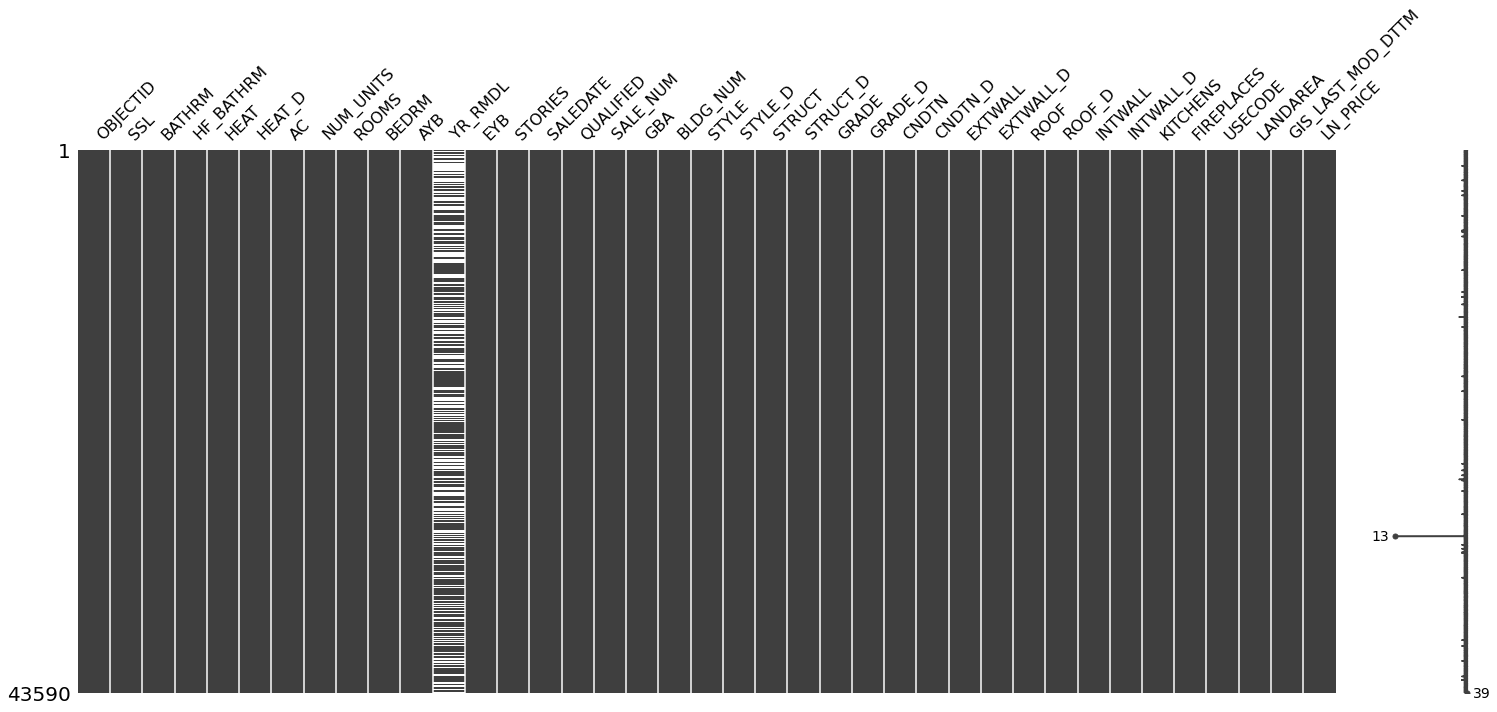

In [4]:
miss.matrix(train)

In [5]:
# Only houses that are sold
train = train[train.LN_PRICE > 0]
test = test[test.LN_PRICE > 0]

# Remove variables which are not of interest
train = train[['BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'STORIES', 'GBA', 'LANDAREA', 'LN_PRICE']]
test = test[['BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'STORIES', 'GBA', 'LANDAREA', 'LN_PRICE']]

# Remove all NA values
train = train.dropna()
test = test.dropna()

test.shape

(14522, 9)

In [6]:
train_y = train[['LN_PRICE']] # OUTCOME: log selling price (some houses are ridiculuously expensive)
train_X = train[['BATHRM', 'ROOMS', 'GBA', 'LANDAREA']] # PREDICTORS: simplified for our purposes
test_y = train[['LN_PRICE']] # OUTCOME: log selling price (some houses are ridiculuously expensive)
test_X = train[['BATHRM', 'ROOMS', 'GBA', 'LANDAREA']] # PREDICTORS: simplified for our purposes

In [7]:
# Look at the training data
test_X.shape 

(43548, 4)

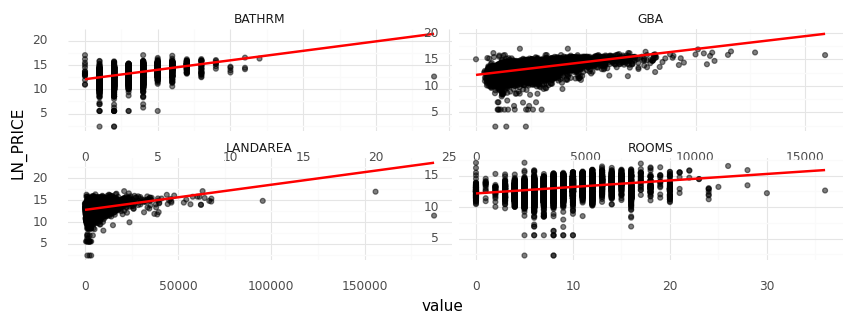

<ggplot: (119432341676)>

In [8]:
# Looking at the relationship of predictors to outcome
D = train_X.copy()
D['LN_PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [9]:
# (1) Setting the fold generator
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','ROOMS','GBA','LANDAREA'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'ROOMS',
                                                                          'GBA',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=30)],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                        

In [10]:
# Check the best fit
search.best_score_ # Mean out-of-sample (CV) error

-0.4797153231831815

In [11]:
# Check the best model
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

In [12]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [13]:
# Check the Mean Squared Error
m.mean_squared_error(test_y,pred_y)

0.44728850853138685

In [14]:
# Check the R-squared
m.r2_score(test_y,pred_y)

0.3971583203916028

In [15]:
# Visualizing the model
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.25) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

ValueError: If using all scalar values, you must pass an index